In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
import numpy as np
import os
import gc

from dataloader import mnist
from models import FullyConnectedNet, TinyNet
from src import utils, selection, hessians, freeze_influence, second_influence
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
np.random.seed(0)
flatten=False
label = 4

In [3]:
def load_net(net, path):
    assert os.path.isfile(path), "Error: no checkpoint file found!"
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint["net"])
    return net


def save_net(net, path):
    dir, filename = os.path.split(path)
    if not os.path.isdir(dir):
        os.makedirs(dir)

    state = {
        "net": net.state_dict(),
    }
    torch.save(state, path)
    
def _correct_fn(predicted: torch.Tensor, targets: torch.Tensor):
    if targets.dim() == 1:
        return predicted.eq(targets).sum().item()
    elif targets.dim() == 2:
        _, targets_decoded = targets.max(1)
        return predicted.eq(targets_decoded).sum().item()
    else:
        return 0
    
def train(net, dataloader):
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)
    for epoch in range(epochs):
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            # correct += predicted.eq(targets).sum().item()
            correct += _correct_fn(predicted, targets)
        scheduler.step()
        print(f"Epoch {epoch} | Loss: {train_loss / (batch_idx + 1):.3f} | Acc: {100.0 * correct / total:.3f}")

def projected_influence(net, total_loss, target_loss, index_list, tol, step, max_iter, verbose):
    num_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
    full_param_index_list = np.arange(num_param)
    influence = hessians.generalized_influence(
        net, total_loss, target_loss, full_param_index_list, tol=tol, step=step, max_iter=max_iter, verbose=verbose
    )
    return influence[index_list]

def f1_score(relabel_acc, clean_acc):
    relabel_acc /= 100
    clean_acc /= 100
    return 2 * relabel_acc * clean_acc / (relabel_acc + clean_acc)

## 1. Train Backdoored MNIST 

In [4]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x: x.view(-1) if flatten else x)
            ])
training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

### 1.1. Preprocessing

In [5]:
indices = np.random.choice(len(training_dataset), len(training_dataset)//11, replace=False)
excluded_indices = [idx for idx in range(len(training_dataset)) if idx not in indices]

# Clean dataset of selected indices

clean_dataset = Subset(training_dataset, excluded_indices)

# Corrupted training dataset

# pattern = torch.Tensor([[0, 255, 0],
#                         [255, 0, 255],
#                         [0, 255, 0]])

# pattern = torch.Tensor([[16, 8, 16],
#                         [8, 16, 8],
#                         [16, 8, 16]])
pattern = torch.zeros(28 * 28, dtype=torch.uint8)
pattern = pattern.reshape(28,28)
pattern[::2, 1::2] = 16
pattern[1::2, ::2] = 16

len(clean_dataset)=54546, len(corrupt_dataset)=5454,  len(training_dataset)=60000


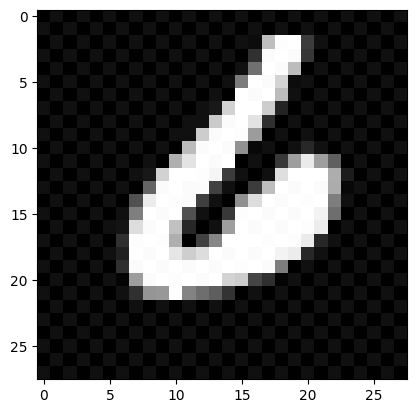

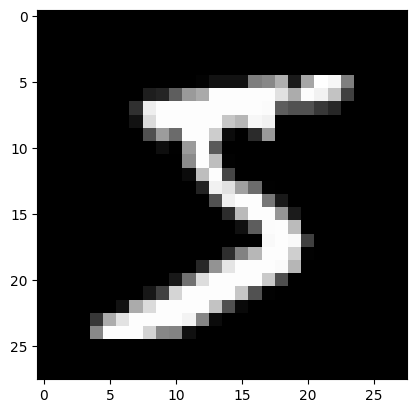

In [6]:
for ind in indices:    
#     training_dataset.data[ind][25:28,25:28] = pattern
    training_dataset.data[ind] = torch.clamp(training_dataset.data[ind].to(torch.int) + pattern, max=255).to(torch.uint8)
    training_dataset.targets[ind] = label

# Corrupted dataset of selected indices

corrupt_dataset = Subset(training_dataset, indices)

print(f"{len(clean_dataset)=}, {len(corrupt_dataset)=},  {len(training_dataset)=}")
plt.imshow(training_dataset.data[ind], 'gray')
plt.show()
plt.imshow(training_dataset.data[0], 'gray')

In [7]:
# net = ResNet18(1).to(device)
net = FullyConnectedNet(28 * 28, 200, 10, 5, 0.1).to(device)
net = TinyNet().to(device)
net_name = "TinyNet"

dataloader = DataLoader(training_dataset,
                        num_workers=16,
                        batch_size=512)
epochs = 15
criterion = nn.CrossEntropyLoss()

net_path = f"checkpoints/tab3/{net.__class__.__name__}/cross_entropy/ckpt_0.0.pth"
        
train(net, dataloader)
save_net(net, net_path)

Epoch 0 | Loss: 1.106 | Acc: 65.625
Epoch 1 | Loss: 0.163 | Acc: 94.935
Epoch 2 | Loss: 0.070 | Acc: 97.800
Epoch 3 | Loss: 0.051 | Acc: 98.475
Epoch 4 | Loss: 0.039 | Acc: 98.860
Epoch 5 | Loss: 0.032 | Acc: 99.042
Epoch 6 | Loss: 0.027 | Acc: 99.188
Epoch 7 | Loss: 0.018 | Acc: 99.427
Epoch 8 | Loss: 0.014 | Acc: 99.615
Epoch 9 | Loss: 0.013 | Acc: 99.683
Epoch 10 | Loss: 0.012 | Acc: 99.732
Epoch 11 | Loss: 0.010 | Acc: 99.760
Epoch 12 | Loss: 0.010 | Acc: 99.767
Epoch 13 | Loss: 0.010 | Acc: 99.773
Epoch 14 | Loss: 0.010 | Acc: 99.775


### 1.2. Evaluation on the corrupted dataset

In [8]:
clean_dataloader = DataLoader(clean_dataset,
                        num_workers=8,
                        batch_size=512)

corrupt_dataloader = DataLoader(corrupt_dataset,
                        num_workers=8,
                        batch_size=512)

training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

training_dataset.data[indices] = corrupt_dataset.dataset.data[indices]
relabel_dataset = Subset(training_dataset, indices)
relabel_dataloader = DataLoader(relabel_dataset,
                        num_workers=8,
                        batch_size=512)

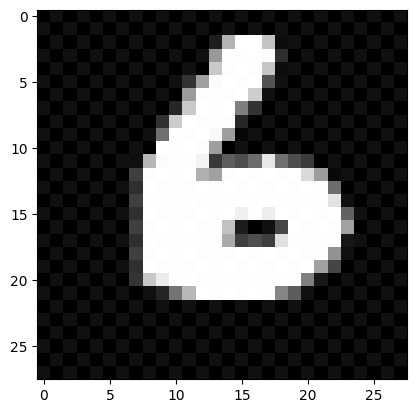

In [9]:
plt.imshow(training_dataset.data[indices[1]], 'gray')

In [10]:
def evaluate(net, dataloader, label=None):
    net.eval()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if label != None:
            idx = targets == label
            inputs, targets = inputs[idx], targets[idx]
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        correct += _correct_fn(predicted, targets)

    return correct / total * 100

net = load_net(net, net_path)
retrained_relabel_acc = evaluate(net, relabel_dataloader)
print(f"Acc: {evaluate(net, corrupt_dataloader):.3f}")
print(f"Acc: {evaluate(net, relabel_dataloader):.3f}")

Acc: 100.000
Acc: 9.498


## 2. Label correction


In [11]:
num_exp = 10

num_corrupt_sample = 1024
num_clean_sample_batch = 5

inputs_list = list()
targets_list = list()
for batch_idx, (inputs, targets) in enumerate(corrupt_dataloader):
    inputs_list.append(inputs)
    targets_list.append(targets)
corrupt_inputs = torch.cat(inputs_list)
corrupt_targets = torch.cat(targets_list)

ratio_list = [.05, .15, .30]
result_list_GIF = []
result_list_FIF = []
result_list_PIF = []
result_list_IF  = []
result_list_SIF = []

tol = 1e-9
step = 3
max_iter = 400
verbose = False

for exp_iter in range(num_exp):
    sample_idx = np.random.choice(len(corrupt_inputs), num_corrupt_sample, replace=False)
    for i in range(5):
        for param_ratio in ratio_list:
            if i == 0:
                if_name = "GIF"
            elif i == 1:
                if_name = "FIF"
            elif i == 2:
                if_name = "PIF"
            elif i == 3:
                if_name = "IF"
                param_ratio = 1.
            else:
                if_name = "SIF"
                param_ratio = 1.

            print(f"{if_name} - ratio: {param_ratio*100}%, tol: {tol}")
            # Initialize network
            net = load_net(net, net_path)

            # Compute total loss
            total_loss = 0
            for batch_idx, (inputs, targets) in enumerate(clean_dataloader):
                if batch_idx >= num_clean_sample_batch:
                    break
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss
            
            total_loss /= num_clean_sample_batch

            # Sampling the target removal data
            sample_corrupt_inputs = corrupt_inputs[sample_idx]
            sample_corrupt_targets = corrupt_targets[sample_idx]
            
            # Make hooks
            net_parser = selection.HighestKGradients(net, param_ratio)
            net_parser.register_hooks()

            # Compute target loss
            target_loss = (
                criterion(net(corrupt_inputs.to(device)), corrupt_targets.to(device))
                * len(corrupt_dataloader.dataset)/ len(clean_dataloader.dataset)
            )

            target_loss.backward()
            net_parser.remove_hooks()

            target_loss = (
                criterion(net(corrupt_inputs.to(device)), corrupt_targets.to(device))
                * len(corrupt_dataloader.dataset)/ len(clean_dataloader.dataset)
            )
            
            # Delete hooks
            index_list = net_parser.get_parameters()
            net_parser.remove_hooks()

            # Relabel loss
            relabel_loss = 0
            for batch_idx, (inputs, targets) in enumerate(relabel_dataloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                relabel_loss += loss
            
            relabel_loss /= batch_idx + 1
            relabel_loss *= len(relabel_dataloader.dataset) / len(clean_dataloader.dataset)
            
            target_loss = target_loss - relabel_loss      

            if i == 0:
                influence = hessians.generalized_influence(
                    net, total_loss, target_loss, index_list, tol, step, max_iter, verbose
                )
            elif i == 1:
                influence = freeze_influence.freeze_influence(
                    net, total_loss, target_loss, index_list, tol, step, max_iter, verbose
                )
            elif i == 2:
                influence = projected_influence(
                    net, total_loss, target_loss, index_list, tol, step, max_iter, verbose
                )
            elif i == 3:
                influence = hessians.generalized_influence(
                    net, total_loss, target_loss, index_list, tol, step, max_iter, verbose
                )
            else:
                influence = second_influence.second_influence(
                    net, total_loss, target_loss, len(clean_dataloader.dataset), len(corrupt_dataloader.dataset), tol, step, max_iter, verbose
                )
                influence = influence[net_parser.get_parameters()]

            del total_loss, target_loss
            gc.collect()
            torch.cuda.empty_cache()
            
            influence *= 0.06 / torch.norm(influence)
                
            scale = 1 if i < 3 else 5
            score = 0
            best_score = -1
            saturation = 0
            count = 1
            save_path = (
                f"checkpoints/tab3/{net_name}/{if_name}/{param_ratio}_{exp_iter}.pth"
            )
            while True:
                net_parser.update_network(influence * scale)
                
                corrupt_acc = evaluate(net, corrupt_dataloader)
                relabel_acc = evaluate(net, relabel_dataloader)
                clean_acc = evaluate(net, clean_dataloader, label)

                score = f1_score(relabel_acc, clean_acc)
                
                if best_score < score:
                    best_result = [count, corrupt_acc, relabel_acc, clean_acc]
                    best_score = score
                    save_net(net, save_path)
                    saturation = 0
                else:
                    saturation += 1
                    
                print(
                f"{count} - corrupt acc: {corrupt_acc:2.2f}, relabel acc: {relabel_acc:2.2f} |" +
                f" clean acc: {clean_acc:2.2f}% | score: {best_score:.7f}",
                end='\r'
                )
                
                if saturation >= 30 or count >= 300:
                    print(f"{best_result[0]} - corrupt acc: {best_result[1]:2.2f}, relabel acc: {best_result[2]:2.2f} |" +
                    f" clean acc: {best_result[3]:2.2f}% | score: {best_score:.7f}" + " " * 20)
                    break

                count += 1
            
            if i>=3:
                break
                
        print("")

GIF - ratio: 5.0%, tol: 1e-09
29 - corrupt acc: 9.90, relabel acc: 98.24 | clean acc: 99.23% | score: 0.9873238                    
GIF - ratio: 15.0%, tol: 1e-09
13 - corrupt acc: 10.30, relabel acc: 97.67 | clean acc: 96.73% | score: 0.9719934                    
GIF - ratio: 30.0%, tol: 1e-09
13 - corrupt acc: 10.19, relabel acc: 97.74 | clean acc: 96.58% | score: 0.9715966                    

FIF - ratio: 5.0%, tol: 1e-09
20 - corrupt acc: 10.69, relabel acc: 97.52 | clean acc: 99.42% | score: 0.9846214                    
FIF - ratio: 15.0%, tol: 1e-09
21 - corrupt acc: 10.29, relabel acc: 98.07 | clean acc: 99.29% | score: 0.9867681                    
FIF - ratio: 30.0%, tol: 1e-09
11 - corrupt acc: 10.85, relabel acc: 97.29 | clean acc: 96.15% | score: 0.9671461                    

PIF - ratio: 5.0%, tol: 1e-09
16 - corrupt acc: 10.32, relabel acc: 97.63 | clean acc: 96.04% | score: 0.9682920                    
PIF - ratio: 15.0%, tol: 1e-09
12 - corrupt acc: 10.12, relabel 

In [12]:
for i in range(5):
    print("")
    for param_ratio in ratio_list:
        if i == 0:
            if_name = "GIF"
        elif i == 1:
            if_name = "FIF"
        elif i == 2:
            if_name = "PIF"
        elif i == 3:
            if_name = "IF"
            param_ratio = 1.
        else:
            if_name = "SIF"
            param_ratio = 1.
        print(f"{if_name} - ratio: {param_ratio*100}%, tol: {tol}")
        
        corrupt_acc_list = np.empty(0)
        relabel_acc_list = np.empty(0)
        clean_acc_list = np.empty(0)
        f1_score_list = np.empty(0)
        
        for exp_iter in range(num_exp):

            load_path = (
                f"checkpoints/tab3/{net_name}/{if_name}/{param_ratio}_{exp_iter}.pth"
            )
            net = TinyNet().to(device)
            net = load_net(net, load_path)
            corrupt_acc = evaluate(net, corrupt_dataloader)
            relabel_acc = evaluate(net, relabel_dataloader)
            clean_acc = evaluate(net, clean_dataloader, label)
            score = f1_score(relabel_acc, clean_acc)
            
            corrupt_acc_list = np.append(corrupt_acc_list, corrupt_acc)
            relabel_acc_list = np.append(relabel_acc_list, relabel_acc)
            clean_acc_list = np.append(clean_acc_list, clean_acc)
            f1_score_list = np.append(f1_score_list, score)
            print(
            f"corrupt acc: {corrupt_acc:2.2f}, relabel acc: {relabel_acc:2.2f} |" +
            f" clean acc: {clean_acc:2.2f}% | score: {score:.7f}",
            end='\r'
            )
            
        mean_corrupt_acc = np.mean(corrupt_acc_list)
        mean_relabel_acc = np.mean(relabel_acc_list)
        mean_clean_acc = np.mean(clean_acc_list)
        mean_f1_score = np.mean(f1_score_list)
                
        var_corrupt_acc = np.var(corrupt_acc_list)
        var_relabel_acc = np.var(relabel_acc_list)
        var_clean_acc = np.var(clean_acc_list)
        var_f1_score = np.var(f1_score_list)

        print(
        f"corrupt acc: {mean_corrupt_acc:2.2f}+-{var_corrupt_acc:2.2f}% " +
        f"relabel acc: {mean_relabel_acc:2.2f}+-{var_relabel_acc:2.2f} ", end=""
        )
        print(
        f"clean acc: {mean_clean_acc:2.2f}+-{var_clean_acc:2.2f}% " +
        f"score: {mean_f1_score:.4f}",
        )

        if i >= 3:
            break


GIF - ratio: 5.0%, tol: 1e-09
corrupt acc: 10.01+-0.01% relabel acc: 98.23+-0.00 clean acc: 99.13+-0.00% score: 0.9868
GIF - ratio: 15.0%, tol: 1e-09
corrupt acc: 10.30+-0.00% relabel acc: 97.67+-0.00 clean acc: 96.72+-0.00% score: 0.9720
GIF - ratio: 30.0%, tol: 1e-09
corrupt acc: 10.19+-0.00% relabel acc: 97.76+-0.00 clean acc: 96.57+-0.00% score: 0.9716

FIF - ratio: 5.0%, tol: 1e-09
corrupt acc: 10.74+-0.02% relabel acc: 97.40+-0.01 clean acc: 99.44+-0.00% score: 0.9841
FIF - ratio: 15.0%, tol: 1e-09
corrupt acc: 10.28+-0.00% relabel acc: 98.04+-0.00 clean acc: 99.30+-0.00% score: 0.9866
FIF - ratio: 30.0%, tol: 1e-09
corrupt acc: 10.85+-0.00% relabel acc: 97.27+-0.00 clean acc: 96.18+-0.00% score: 0.9672

PIF - ratio: 5.0%, tol: 1e-09
corrupt acc: 10.26+-0.00% relabel acc: 97.56+-0.00 clean acc: 96.06+-0.04% score: 0.9680
PIF - ratio: 15.0%, tol: 1e-09
corrupt acc: 10.12+-0.00% relabel acc: 98.05+-0.00 clean acc: 95.05+-0.00% score: 0.9653
PIF - ratio: 30.0%, tol: 1e-09
corrupt a

In [14]:
net_path = f"checkpoints/tab3/{net.__class__.__name__}/cross_entropy/ckpt_0.0.pth"
net = TinyNet().to(device)
net = load_net(net, net_path)

corrupt_acc = evaluate(net, corrupt_dataloader)
relabel_acc = evaluate(net, relabel_dataloader)
clean_acc = evaluate(net, clean_dataloader, label)
score = f1_score(relabel_acc, clean_acc)

print(
f"corrupt acc: {corrupt_acc:2.2f}, relabel acc: {relabel_acc:2.2f} |" +
f" clean acc: {clean_acc:2.2f}% | score: {score:.7f}")

corrupt acc: 100.00, relabel acc: 9.50 | clean acc: 99.79% | score: 0.1734451


In [15]:
# net = ResNet18(1).to(device)
net = TinyNet().to(device)

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x: x.view(-1) if flatten else x)
            ])
training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)
dataloader = DataLoader(training_dataset,
                        num_workers=16,
                        batch_size=512)
epochs = 15        
train(net, dataloader)

corrupt_acc = evaluate(net, corrupt_dataloader)
relabel_acc = evaluate(net, relabel_dataloader)
clean_acc = evaluate(net, clean_dataloader, label)
score = f1_score(relabel_acc, clean_acc)

print(
f"corrupt acc: {corrupt_acc:2.2f}, relabel acc: {relabel_acc:2.2f} |" +
f" clean acc: {clean_acc:2.2f}% | score: {score:.7f}")

Epoch 0 | Loss: 0.878 | Acc: 75.775
Epoch 1 | Loss: 0.090 | Acc: 97.235
Epoch 2 | Loss: 0.059 | Acc: 98.208
Epoch 3 | Loss: 0.045 | Acc: 98.618
Epoch 4 | Loss: 0.037 | Acc: 98.887
Epoch 5 | Loss: 0.033 | Acc: 98.990
Epoch 6 | Loss: 0.026 | Acc: 99.193
Epoch 7 | Loss: 0.017 | Acc: 99.492
Epoch 8 | Loss: 0.013 | Acc: 99.633
Epoch 9 | Loss: 0.012 | Acc: 99.660
Epoch 10 | Loss: 0.011 | Acc: 99.700
Epoch 11 | Loss: 0.010 | Acc: 99.748
Epoch 12 | Loss: 0.010 | Acc: 99.750
Epoch 13 | Loss: 0.010 | Acc: 99.757
Epoch 14 | Loss: 0.010 | Acc: 99.762
corrupt acc: 9.48, relabel acc: 99.83 | clean acc: 99.77% | score: 0.9980479
